In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans, KMeans, SpectralCoclustering, SpectralClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import normalize as Norm
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score, f1_score
from sklearn.utils.extmath import randomized_svd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import adjusted_rand_score

from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix,  dok_matrix, diags
from scipy.linalg import sqrtm, pinv

In [3]:
'''
BiPartFit: Given data and number of clusters, runs Kmeans on reduced dimensions of the features (terms) and
returns labels for what cluster each row is in, and also the centroid points, (used for finding top documents)
  Params:
    1. Data, term-document matrix in csr format
    2. k, cluster size
    3. returnCost, do we want to know inertia score
    4. normalize, do we want to normalize the input to the KMeans algo
    
  Returns:
    1. Labels, vector of documents with cluster # that the document has been assigned to
    2. Centroid Points
    3. VT, how you can project the original document data onto the dim reduction 
    4. Heterogeneity for kMeans
'''
def BiPartFit(data, k, n_init_ = 50, returnCost = False, normalize = False, verbose = False):
  #We could normalize the data from term-frequencies to just whether words occur in a document or not, possibly explore


  #Form D1, An, D2
  numWords = data.shape[0]
  numDocs = data.shape[1]
  D1, An, D2 = FormComponents(data)

  num_components = int(np.ceil(np.log2(k)))
  print(f"Dimension of BiPartFit: {num_components}")

  #Compute the (2, l+1) right and left singular vectors
  U, S, VT = randomized_svd(An, n_components = num_components+1, random_state = None)

  #Drop the first right and left singular vectors
  U = U[:, 1:]
  VT = VT[1:,:]

  #Form Z
  Z = FormZ(D1, D2, U, VT)


  #Run Kmeans on the l-dimensional data to obtain K partitioning. 
  #Documents will be the rows of the Z from row (m+1) to the end. We can then use this mapping to get clusters of documents
  if returnCost:
    WordDocClusters, cluster_centers, _, kmeans = KMeansFit(Z, k, n_init_ = n_init_, returnCost = returnCost, normalize = normalize, passObject = True)
  else:
    WordDocClusters, cluster_centers = KMeansFit(Z, k, n_init_ = n_init_, returnCost = returnCost, normalize = normalize)

  DocClusters = WordDocClusters[numWords:]
  WordClusters = WordDocClusters[:numWords]
  if returnCost:
    cost = -1*kmeans.score(Z[numWords:])


  if verbose:
    TopDocs(Z[numWords:], DocClusters, cluster_centers, k, 5)


  if returnCost:
    return DocClusters, cluster_centers, VT, cost
  else:
    return DocClusters, WordClusters, cluster_centers, VT


def FormComponents(data):
  D1 = diags(np.ravel((np.power(data.sum(axis = 1), -1/2))), format = "csr")
  D2 = diags(np.ravel((np.power(data.sum(axis = 0), -1/2))), format = "csr")
  An = D1 @ data @ D2
  return D1, An, D2

def FormZ(D1, D2, U, VT):
  Z1 = D1@U
  Z2  = D2@(VT.transpose())
  Z = np.vstack((Z1, Z2))
  return Z


In [4]:
'''
KMeansFit: Given data and number of clusters, runs Kmeans and returns labels for what cluster each row is in,
          and also the centroid points, (used for finding top documents)
  Params:
    1. Data, term-document matrix in csr format
    2. k, cluster size
    3. n_init_, number of different seeds we want to run our algo on
    
  Returns:
    1. Labels, vector of documents with cluster # that the document has been assigned to
    2. Centroid Points
'''
def KMeansFit(data, k, n_init_ = 25, returnCost = False, normalize = True, passObject = False):
  #First renormalize all features to unit length so that we can use cosine similarity as the distance metric
  if normalize:
    data = Norm(data)

  #Now run the algorithm multiple times with different seeds, only keeping the run with the lowest heterogeneity
  kmeans = KMeans(n_clusters = k, init = "k-means++", n_init = n_init_).fit(data)
  final_cluster_assignment = kmeans.labels_
  cluster_centers = kmeans.cluster_centers_
  final_heterogeneity = kmeans.inertia_

  if returnCost and passObject:
    return final_cluster_assignment, cluster_centers, final_heterogeneity, kmeans
  elif returnCost:
    return final_cluster_assignment, cluster_centers, final_heterogeneity
  else:
    return final_cluster_assignment, cluster_centers


In [3]:
'''
GMMFit: Given data and number of clusters, runs GMM and returns labels for what cluster each row is in,
          and also the centroid points, (used for finding top documents)
  Params:
    1. Data, term-document matrix in csr format
    2. k, cluster size
    3. n_init_, number of different seeds we want to run our algo on
    
  Returns:
    1. Labels, vector of documents with cluster # that the document has been assigned to
    2. Centroid Points
'''
def GMMFit(data, k, n_init_ = 10, returnCost = False, normalize = True, passObject = False):
  #First renormalize all features to unit length so that we can use cosine similarity as the distance metric
  if normalize:
    data = Norm(data)

  #Now run the algorithm multiple times with different seeds, only keeping the run with the lowest heterogeneity
  gmmMod = GaussianMixture(n_components = k, covariance_type = 'diag', n_init = n_init_)
  final_cluster_assignment = gmmMod.fit_predict(data)
  cluster_centers = gmmMod.means_
  final_heterogeneity = gmmMod.bic(data)

  if returnCost and passObject:
    return final_cluster_assignment, cluster_centers, final_heterogeneity, kmeans
  elif returnCost:
    return final_cluster_assignment, cluster_centers, final_heterogeneity
  else:
    return final_cluster_assignment, cluster_centers

In [5]:
'''
SVDkMeansFit: Given data and number of clusters, runs Kmeans on reduced dimensions of the features (terms) and
returns labels for what cluster each row is in, and also the centroid points, (used for finding top documents)
  Params:
    1. Data, term-document matrix in csr format
    2. k, cluster size
    3. dimensions, number of singular vectors we want to compute
    4. n_init_, number of different seeds we want to run our algo on
    
  Returns:
    1. Labels, vector of documents with cluster # that the document has been assigned to
    2. Centroid Points
    3. object for projecting data points into embedded space
    4. Heterogeneity for kMeans 
'''
def PCAkMeansFit(data, k, dimensions = 20, n_init_ = 25, returnCost = False, normalize = False):
  svd = TruncatedSVD(n_components = dimensions)
  transformedData = svd.fit_transform(data)
  labels, cluster_centers, cost = KMeansFit(transformedData, k, n_init_, returnCost = returnCost, normalize = normalize)
  if returnCost:
    return labels, cluster_centers, svd, cost
  else:
    return labels, cluster_centers, svd


In [6]:
"""
  Returns: vector corresponding to which basis had smallest projection distance
  Assumption: Bases is a list of matrices

  I might also want to keep track of the objective function descent
"""
def clustAssign(data, Bases):
  Distances = np.ndarray((data.shape[0], len(Bases)), dtype = float)
  for idx, U in enumerate(Bases):
    projection = data @ U
    proj_dist = np.linalg.norm(projection, axis = 1)
    Distances[:, idx] = np.ravel(proj_dist)
  closest_cluster = np.argmin(Distances, axis = 1)
  return closest_cluster


'''
  Returns a list (size subspaces) of bases given dimensions of data and dimensions of each individual basis element
'''
def drawRandomBases(ambientDim, basisDim, subspaces):
  subspaceList = list()
  for i in range(subspaces):
    points = np.random.normal(size = ambientDim*basisDim)
    X = np.reshape(points, (ambientDim, basisDim))
    U = X @ pinv((sqrtm(X.T @ X)))
    subspaceList.append(U)
  return subspaceList




'''
#  Returns a list (size subspaces) of bases given
'''
def drawSVDBases(data, clust_assignments, basisDim, subspaces):
  subspaceList = list()
  for i in range(subspaces):
    cluster = data[clust_assignments == i]
    U, _, VT = randomized_svd(cluster, n_components = basisDim, random_state = None)
    subspaceList.append(VT.T)

  return subspaceList



def affinityMatrix(cluster_assignments):
  distances = pairwise_distances(cluster_assignments, metric = "hamming")
  return 1 - distances

def checkBasis(data, Bases, subspaces):
  if Bases is None:
    return False
  clusters = clustAssign(data, Bases)
  for i in range(subspaces):
    count = data[clusters ==i].shape[0]
    if data[clusters == i].shape[0] < 5:
      return False
  return True




def EKSS(data, subspaces, dimension, K, B, T, q = 0):
  #Create an array that holds cluster assignments for each of our runs
  clust_assignments = np.ndarray((data.shape[0], B))

  #Fill Array
  for b in range(B):
    Bases = drawRandomBases(data.shape[1], dimension, subspaces)

    bClusters = clustAssign(data, Bases)
    for t in range(T):
      Bases = drawSVDBases(data, bClusters, dimension, subspaces)
      bClusters = clustAssign(data, Bases)

    if (b % int(B/10) == 0): 
      print(f"Completed {b} weak learners out of {B}")
    clust_assignments[:, b] = np.ravel(bClusters)
  

  #Create affinity matrix
  print("Creating Affinity Matrix")
  A = affinityMatrix(clust_assignments)
  print("Running Spectral Clustering")

  #Now run spectral clustering on this affinity matrix (assing_labels is hyperparameter, look at docs)
  clustering = SpectralClustering(n_clusters = K, assign_labels = 'kmeans', affinity = 'precomputed').fit(A)
  FinalClusters = clustering.labels_


  return FinalClusters

#Import and Clean Classic3 Dataset

In [4]:
#Now, go through wiki file and create dict so that we can convert to dataframe
#Or, equivalently a sparse matrix
data = pd.read_csv("train.csv")

In [5]:
SIZE = 10000
np.random.seed(10)
idx = np.random.choice(data.shape[0], SIZE)
TrueLabels = (data.iloc[idx,0]).to_numpy()
TrueLabels = TrueLabels - 1

In [6]:
vectorizer = TfidfVectorizer()
TFIDFData = vectorizer.fit_transform(data.iloc[idx,2])

In [7]:
print(TrueLabels.shape)
print(100*(1-csr_matrix.count_nonzero(TFIDFData)/(TFIDFData.shape[0]*TFIDFData.shape[1])))

(10000,)
99.87552487428161


In [8]:
print(np.bincount(TrueLabels))

[2477 2490 2560 2473]


In [9]:
TFIDFData.shape

(10000, 22272)

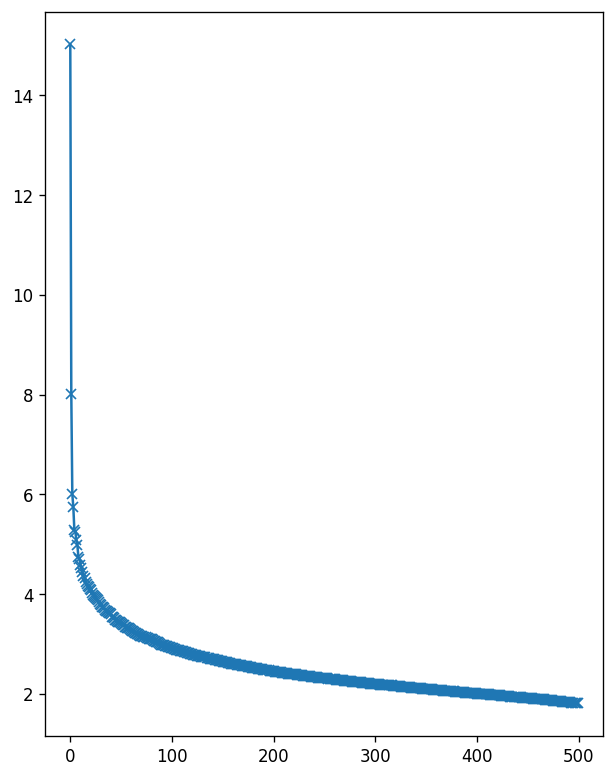

In [20]:
svd = TruncatedSVD(n_components = 500)
svd.fit(TFIDFData)
plt.plot(svd.singular_values_, label = "Singular Value Magnitudes", marker = "x")
fig = plt.gcf()
fig.set_size_inches((6,8))
fig.set_dpi(120)

#Find Cluster Labels with EKSS, BP, KM, SVD, etc...


In [ ]:
subspaces = 4
dimension = 4
K = 4
B = 1000
T = 3

labels = EKSS(TFIDFData, subspaces, dimension, K, B, T)

Completed 0 weak learners out of 1000
Completed 100 weak learners out of 1000
Completed 200 weak learners out of 1000
Completed 300 weak learners out of 1000
Completed 400 weak learners out of 1000
Completed 500 weak learners out of 1000
Completed 600 weak learners out of 1000


In [ ]:
clustering = SpectralClustering(n_clusters=2,assign_labels='discretize',random_state=0).fit(TFIDFData)
BPlabels = clustering.labels_
#BPlabels, _, _, cost = BiPartFit(TFIDFData.transpose(), 4, n_init_ = 50, returnCost = True)
KMlabels, _, cost = KMeansFit(TFIDFData, 4, returnCost = True)
SVDlabels, _, _, cost = PCAkMeansFit(TFIDFData, 4, dimensions = 250, returnCost = True, normalize = False)

In [10]:
GMMlabels, _, cost = GMMFit(TFIDFData.toarray(), 4, returnCost = True)

#Calculate aRI, and Percentage Error

In [11]:
def CalcScore(pred_labels, test_labels, num_classes):
  ErrorRate = 1
  for i in range(num_classes):
    temp_pred_labels = (pred_labels + i) % (num_classes)
    ErrorRate = min((np.sum(temp_pred_labels != test_labels))/len(test_labels), ErrorRate)
  return ErrorRate


In [12]:
def CalcF1Score(pred_labels, test_labels, num_classes):
  F1Score = 0
  for i in range(num_classes):
    temp_pred_labels = (pred_labels + i) % (num_classes)
    F1Score = f1_score(test_labels, temp_pred_labels, average = 'macro')
  return F1Score

In [ ]:
numclasses = 4
EKSSerror = CalcScore(labels, TrueLabels, numclasses)
KMerror = CalcScore(KMlabels, TrueLabels, numclasses)
BPerror = CalcScore(BPlabels, TrueLabels, numclasses)
SVDerror = CalcScore(SVDlabels, TrueLabels, numclasses)
print(f"EKSS error rate: {EKSSerror}")
print(f"KM error rate: {KMerror}")
print(f"BP error rate: {BPerror}")
print(f"SVD error rate: {SVDerror}")

numclasses = 4
EKSSF1 = CalcF1Score(labels, TrueLabels, numclasses)
KMF1= CalcF1Score(KMlabels, TrueLabels, numclasses)
BPF1 = CalcF1Score(BPlabels, TrueLabels, numclasses)
SVDF1 = CalcF1Score(SVDlabels, TrueLabels, numclasses)
print(f"EKSS F1: {EKSSF1}")
print(f"KM F1: {KMF1}")
print(f"BP F1: {BPF1}")
print(f"SVD F1: {SVDF1}")

In [13]:
numclasses = 4
GMMerror = CalcScore(GMMlabels, TrueLabels, numclasses)
print(f"GMM error rate: {GMMerror}")

GMMF1 = CalcF1Score(GMMlabels, TrueLabels, numclasses)
print(f"GMM F1: {GMMF1}")

print(f"GMM adjusted Rand index: {adjusted_rand_score(GMMlabels, TrueLabels)}")

GMM error rate: 0.6302
GMM F1: 0.1964596874924796
GMM adjusted Rand index: 0.33549357006255937


In [ ]:
print(f"EKSS adjsuted Rand index: {adjusted_rand_score(labels, TrueLabels)}")
print(f"KM adjsuted Rand index: {adjusted_rand_score(KMlabels, TrueLabels)}")
print(f"BP adjsuted Rand index: {adjusted_rand_score(BPlabels, TrueLabels)}")
print(f"SVD adjsuted Rand index: {adjusted_rand_score(SVDlabels, TrueLabels)}")